In [1]:
import copy
import numpy as np
import pandas as pd

from src.common.functions import get_feature_importance
%cd /home/heza7322/PycharmProjects/missing-value-handling-in-carts
from src.binary_tree import BinaryTree
from src.trinary_tree import TrinaryTree
from src.weighted_tree import WeightedTree
from src.common.functions import get_indices, calculate_loss, fit_response


/home/heza7322/PycharmProjects/missing-value-handling-in-carts


In [49]:
n = 10000
seed = 11
np.random.seed(seed)
df = pd.DataFrame(index = range(n))
df['cont_normal'] = np.random.normal(3,2,n)
df['cont_linear'] = np.arange(n)
df['cont_stairs'] = np.concatenate([np.ones(int(i)) * i for i in np.linspace(0,100000,10)])[:n]
df['cat_version'] = np.random.choice(['basic','pro','extra','none'],n,p = [0.5,0.22,0.18,0.1])
df['cat_gender'] = np.random.choice(['male','female'],n,p = [0.59,1-0.59])

# Reduce unique value space
df['cont_normal'] = df['cont_normal'].round(0)
df['cont_stairs'] = df['cont_stairs'] .round(0)
df['cont_linear'] = np.floor(df['cont_linear']/100)*100

features = ['cont_normal','cont_linear','cont_stairs','cat_version','cat_gender']

left_00 = df['cont_normal']<df['cont_normal'].quantile(0.7)
left_10 = df['cat_version'].isin(['basic','edftra'])
left_11 = df['cat_gender']=='male'
left_20 = df['cont_stairs'] < df['cont_stairs'].quantile(0.4)
left_21 = df['cont_stairs'] < df['cont_stairs'].quantile(0.4)
left_22 = df['cat_version'].isin(['basic','none'])
left_23 = df['cont_linear'] < df['cont_linear'].mean()

index_30 = left_00 & left_10 & left_20
index_31 = left_00 & left_10 & (~left_20)
index_32 = left_00 & (~left_10) & left_21
index_33 = left_00 & (~left_10) & (~left_21)
index_34 = (~left_00) & left_11 & left_22
index_35 = (~left_00) & left_11 & (~left_22)
index_36 = (~left_00) & (~left_11) & left_23
index_37 = (~left_00) & (~left_11) & (~left_23)

terminal_node_indices = [index_30, index_31, index_32, index_33, index_34, index_35, index_36, index_37]
mus = np.arange(8)*10

for index,mu in zip(terminal_node_indices,mus):
    df.loc[index,'y'] = np.random.normal(mu,1)

# Test train split
df['test'] = False
index_train = np.random.choice(df.index,int(n*0.2))
df.loc[index_train,'test'] = True

max_depth = 3
min_samples_leaf = 5
tree_types = {'majority': BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='majority'),
              'mia':      BinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf,missing_rule='mia'),
              'trinary': TrinaryTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf),
              'weighted': WeightedTree(max_depth=max_depth, min_samples_leaf=min_samples_leaf)}


In [50]:
# Missingness of different frequencies
missing_probs = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

dfs = {0: df.copy()}

for missing_prob in missing_probs[1:]:
    dfs[missing_prob] = df.copy()
    for feature in features:
        to_remove = np.random.binomial(1,missing_prob,len(df)) == 1
        dfs[missing_prob].loc[to_remove,feature] = np.nan

In [51]:
results = pd.DataFrame(columns = [key for key in tree_types], index = missing_probs)

In [56]:
# Fit trees
for missing_prob in missing_probs:
    print(missing_prob)
    X_train = dfs[missing_prob].loc[~dfs[missing_prob]['test'],features]
    y_train = dfs[missing_prob].loc[~dfs[missing_prob]['test'],'y']
    X_test  = dfs[missing_prob].loc[dfs[missing_prob]['test'],features]
    y_test  = dfs[missing_prob].loc[dfs[missing_prob]['test'],'y']
    for tree_name in tree_types:
        tree = copy.deepcopy(tree_types[tree_name])
        tree.fit(X_train,y_train)

        y_hat = tree.predict()
        mse = (y_test-y_hat).pow(2).mean()
    results.loc[missing_prob,tree_name] = mse
    print(tree_name)

0


KeyboardInterrupt: 

<Axes: >

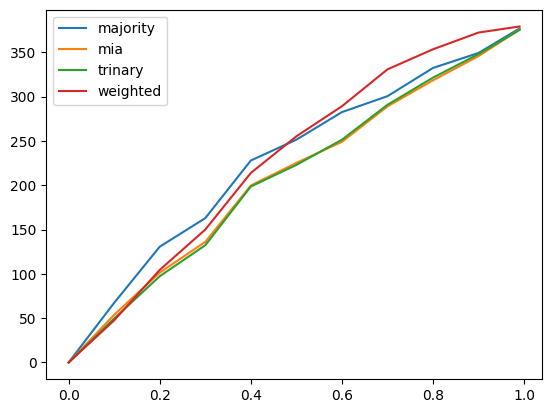

In [57]:
results.plot()